<a href="https://colab.research.google.com/github/sokkerstar123/Capstone/blob/main/notebooks/final_analysis_and_plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project:
# An AI-powered pipeline that automatically generates  summaries for YouTube videos via Knowledge Distillation

This notebook contains the reproducible code for fine-tuning a **Flan-T5** model using a synthetic dataset generated by Gemini 2.0 Flash. It includes the data loading, training pipeline, inference logic, and quantitative evaluation (ROUGE and Semantic Similarity).

**Prerequisites:**
Ensure the training dataset file `gold_dataset_merged_final.csv` is present in the current working directory.

## 1. Data Engineering (ETL)

We start by loading the raw `jamescalam/youtube-transcriptions` dataset from Hugging Face. We perform aggregation to combine fragmented text segments into full video transcripts.

In [1]:
# 1. Environment Setup & Dependencies
# Installing necessary libraries for transformer models, vector databases, and evaluation metrics.

!pip install -q transformers>=4.30.0 torch>=2.0.0 youtube-transcript-api sentencepiece pandas numpy seaborn matplotlib scikit-learn rouge-score sentence-transformers datasets evaluate accelerate

import os
import re
import torch
import evaluate
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import Dataset, load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from sentence_transformers import SentenceTransformer, util
from rouge_score import rouge_scorer

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on device: {device}")

Running on device: cuda


In [2]:
# Load raw dataset
print("[INFO] Loading raw data from Hugging Face...")
raw_dataset = load_dataset('jamescalam/youtube-transcriptions', split='train')
df_raw = pd.DataFrame(raw_dataset)

# Data Cleaning & Aggregation
print("[INFO] Aggregating text segments by video_id...")
# Convert text to string just in case
df_raw['text'] = df_raw['text'].astype(str)

# Group by video metadata and join text segments
group_cols = ['title', 'published', 'url', 'video_id', 'channel_id']
df_processed = df_raw.groupby(group_cols)['text'].apply(' '.join).reset_index()
df_processed.rename(columns={'text': 'full_transcript'}, inplace=True)

print(f"[INFO] Processed {len(df_processed)} unique videos.")
print(df_processed[['title', 'full_transcript']].head(3))

# Note: In the actual pipeline, we then merged this with Gemini-generated summaries
# to create 'gold_dataset_merged_final.csv'.
# For this notebook, we will proceed by loading that pre-computed CSV.

[INFO] Loading raw data from Hugging Face...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

youtube-transcriptions.jsonl:   0%|          | 0.00/79.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/208619 [00:00<?, ? examples/s]

[INFO] Aggregating text segments by video_id...
[INFO] Processed 701 unique videos.
                                               title  \
0                             $5 MILLION AI for FREE   
1  1 week out from SPARTAN Race + How to bake a s...   
2  10-minute Bodyweight Back &amp; Shoulders Bedr...   

                                     full_transcript  
0  Imagine an AI where all in the same model you ...  
1  What's going on guys welcome back to another S...  
2  You know in the coming months, leadership at e...  


## 2. Data Acquisition & Preprocessing

Loading the YouTube Transcriptions dataset and preparing it for fine-tuning. We utilize a pre-generated "Gold Standard" dataset (distilled from Gemini 2.0) to overcome the lack of labeled summaries.

In [6]:
# Configuration
FILENAME = "gold_dataset_merged_final.csv"
MODEL_CHECKPOINT = "google/flan-t5-base"

# 2.1 Load Data
# Define potential paths to check
# 1. Current directory (Colab default or local root)
# 2. Relative path for GitHub structure (notebooks/ -> data/)
possible_paths = [
    FILENAME,
    f"../data/{FILENAME}"
]

data_path = None

# Check if file exists in any known location
for path in possible_paths:
    if os.path.exists(path):
        data_path = path
        print(f"[INFO] Found dataset at: {data_path}")
        break

# If not found, handle Google Colab upload
if data_path is None:
    try:
        import google.colab
        print(f"[WARN] {FILENAME} not found. Please upload it now...")
        from google.colab import files
        uploaded = files.upload()
        if FILENAME in uploaded:
            data_path = FILENAME
        else:
            print("[ERROR] Uploaded file name does not match expected filename.")
    except ImportError:
        # Not running in Colab, and file not found locally
        pass

# Final load logic
if data_path and os.path.exists(data_path):
    print(f"[INFO] Loading dataset...")
    df = pd.read_csv(data_path)

    # Ensure no missing values in critical columns
    df = df.dropna(subset=['target_summary', 'full_transcript'])
    print(f"[INFO] Dataset loaded successfully. Total samples: {len(df)}")
else:
    raise FileNotFoundError(
        f"Could not find {FILENAME} in current directory or '../data/'. "
        "Please ensure the file is uploaded or placed in the correct 'data' folder."
    )


# 2.2 Split Data
# Convert to Hugging Face Dataset format and split 10% for validation/testing

dataset = Dataset.from_pandas(df[['full_transcript', 'target_summary']])
dataset = dataset.train_test_split(test_size=0.1, seed=42)

print("[INFO] Data split completed:")
print(dataset)

[INFO] Found dataset at: gold_dataset_merged_final.csv
[INFO] Loading dataset...
[INFO] Dataset loaded successfully. Total samples: 349
[INFO] Data split completed:
DatasetDict({
    train: Dataset({
        features: ['full_transcript', 'target_summary'],
        num_rows: 314
    })
    test: Dataset({
        features: ['full_transcript', 'target_summary'],
        num_rows: 35
    })
})


## 3. Tokenization & Model Setup

Preparing the data for the Seq2Seq model by tokenizing inputs and targets, and initializing the Flan-T5-Base model.

In [7]:
# 3.1 Initialize Tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def preprocess_function(examples):
    """
    Tokenizes inputs and targets.
    Truncates inputs to 1024 tokens to fit model context.
    """
    # T5 models expect a task prefix
    inputs = ["summarize: " + str(doc) for doc in examples["full_transcript"]]

    # Tokenize inputs
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    # Tokenize targets (labels)
    labels = tokenizer(text_target=examples["target_summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply preprocessing
tokenized_datasets = dataset.map(preprocess_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['full_transcript', 'target_summary'])

# 3.2 Initialize Model
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

Map:   0%|          | 0/314 [00:00<?, ? examples/s]

Map:   0%|          | 0/35 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## 4. Fine-Tuning (Knowledge Distillation)

Training the model using `Seq2SeqTrainer`. We use mixed-precision (FP16) and `Adafactor` optimizer for memory efficiency.

In [8]:
# 4.1 Define Training Arguments
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

training_args = Seq2SeqTrainingArguments(
    output_dir="flan_t5_base_video_summarizer",
    learning_rate=3e-4,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=1,
    logging_steps=10,
    fp16=torch.cuda.is_available(), # Use mixed precision if on GPU
    optim="adafactor",
    gradient_checkpointing=True,
    report_to="none"
)

# 4.2 Initialize Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# 4.3 Start Training
print("[INFO] Starting training...")
trainer.train()

# 4.4 Save Artifacts
save_path = "final_flan_t5_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)
print(f"[INFO] Model saved to {save_path}")

/tmp/ipython-input-1986973015.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


[INFO] Starting training...


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
10,0.000000
20,0.000000
30,0.000000
40,0.000000
50,0.000000
60,0.000000
70,0.000000
80,0.000000
90,0.000000
100,0.000000


[INFO] Model saved to final_flan_t5_model


## 5. Inference Pipeline

Generating summaries for the validation set using the fine-tuned model to assess performance.

In [9]:
# 5.1 Reload Fine-Tuned Model
print("[INFO] Reloading model for inference...")
tokenizer = AutoTokenizer.from_pretrained(save_path)
model = AutoModelForSeq2SeqLM.from_pretrained(save_path).to(device)

# 5.2 Utility Functions
def clean_text_for_inference(text):
    """
    Basic text cleaning.
    """
    if not text: return ""
    # Normalize whitespace
    clean = text.replace("\n", " ")
    # Truncate to approx 4000 chars to fit context window
    return clean[:4000]

def generate_summary(transcript):
    input_text = "summarize: " + clean_text_for_inference(transcript)

    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=1024,
        truncation=True
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=150,
            min_length=40,
            num_beams=4,
            length_penalty=2.0,
            no_repeat_ngram_size=3,
            early_stopping=True
        )

    summary = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # Capitalize first letter
    return summary[0].upper() + summary[1:] if summary else summary

# 5.3 Run Inference on Evaluation Set
test_df = pd.DataFrame(dataset['test'])
print(f"[INFO] Generating summaries for {len(test_df)} validation samples...")

generated_summaries = []
for transcript in tqdm(test_df['full_transcript']):
    generated_summaries.append(generate_summary(transcript))

test_df['generated_summary'] = generated_summaries

[INFO] Reloading model for inference...
[INFO] Generating summaries for 35 validation samples...


100%|██████████| 35/35 [01:25<00:00,  2.46s/it]


## 6. Quantitative Evaluation

Assessing model performance using ROUGE (Lexical Overlap) and Cosine Similarity (Semantic Understanding).

In [10]:
# 6.1 ROUGE Score Calculation
rouge = evaluate.load("rouge")

# Filter out potential empty results
valid_indices = [i for i, s in enumerate(test_df['generated_summary']) if s]
candidates = [test_df['generated_summary'][i] for i in valid_indices]
references = [test_df['target_summary'][i] for i in valid_indices]

rouge_results = rouge.compute(predictions=candidates, references=references, use_stemmer=True)

print("\n=== ROUGE Scores (Lexical) ===")
print(f"ROUGE-1: {rouge_results['rouge1']:.4f}")
print(f"ROUGE-2: {rouge_results['rouge2']:.4f}")
print(f"ROUGE-L: {rouge_results['rougeL']:.4f}")

# 6.2 Semantic Similarity Calculation
sim_model = SentenceTransformer("all-MiniLM-L6-v2")

print("\n[INFO] Computing semantic embeddings...")
cand_embeddings = sim_model.encode(candidates, convert_to_tensor=True)
ref_embeddings = sim_model.encode(references, convert_to_tensor=True)

cosine_scores = []
for i in range(len(candidates)):
    score = util.cos_sim(cand_embeddings[i], ref_embeddings[i]).item()
    cosine_scores.append(score)

avg_semantic_score = np.mean(cosine_scores)
print(f"\n=== Semantic Similarity Score ===")
print(f"Average Cosine Similarity: {avg_semantic_score:.4f}")


=== ROUGE Scores (Lexical) ===
ROUGE-1: 0.2486
ROUGE-2: 0.0503
ROUGE-L: 0.1495


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]


[INFO] Computing semantic embeddings...

=== Semantic Similarity Score ===
Average Cosine Similarity: 0.5966


## 7. Visualizations

Visualizing the trade-off between transcript length and performance, and the gap between lexical vs. semantic understanding.

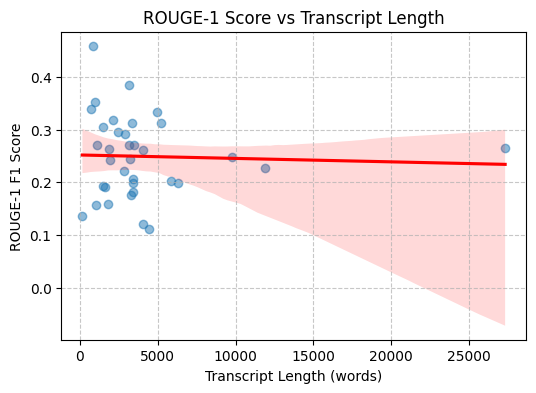

/tmp/ipython-input-3536655256.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Metric Type', y='Score', data=df_comparison, palette="muted", inner="quartile")


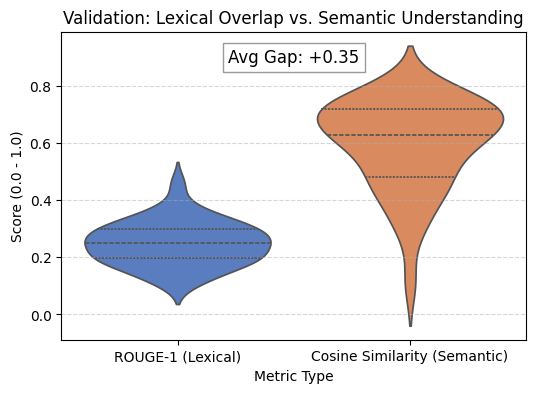

In [13]:
# Helper to count words
def count_words(text):
    return len(text.split()) if isinstance(text, str) else 0

# 7.1 Visual 1: ROUGE Score vs Transcript Length
scorer = rouge_scorer.RougeScorer(['rouge1'], use_stemmer=True)
transcript_lengths = []
instance_rouge_scores = []

# Get source transcripts corresponding to valid predictions
source_texts = [test_df['full_transcript'][i] for i in valid_indices]

for src, pred, ref in zip(source_texts, candidates, references):
    transcript_lengths.append(count_words(src))
    instance_rouge_scores.append(scorer.score(ref, pred)['rouge1'].fmeasure)

plot_data = pd.DataFrame({
    'Transcript Length': transcript_lengths,
    'ROUGE-1 Score': instance_rouge_scores
})

plt.figure(figsize=(6, 4))
sns.regplot(
    data=plot_data,
    x='Transcript Length',
    y='ROUGE-1 Score',
    scatter_kws={'alpha': 0.5},
    line_kws={'color': 'red'}
)
plt.title('ROUGE-1 Score vs Transcript Length')
plt.xlabel('Transcript Length (words)')
plt.ylabel('ROUGE-1 F1 Score')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('visual_rouge_vs_length.png', dpi=300, bbox_inches='tight')
plt.show()

# 7.2 Visual 2: Lexical vs. Semantic Gap
df_comparison = pd.DataFrame({
    'Metric Type': ['ROUGE-1 (Lexical)'] * len(instance_rouge_scores) + ['Cosine Similarity (Semantic)'] * len(cosine_scores),
    'Score': instance_rouge_scores + cosine_scores
})

plt.figure(figsize=(6, 4))
sns.violinplot(x='Metric Type', y='Score', data=df_comparison, palette="muted", inner="quartile")
plt.title('Validation: Lexical Overlap vs. Semantic Understanding')
plt.ylabel('Score (0.0 - 1.0)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Annotation for the gap
avg_gap = np.mean(cosine_scores) - np.mean(instance_rouge_scores)
plt.text(0.5, 0.9, f"Avg Gap: +{avg_gap:.2f}",
         transform=plt.gca().transAxes, ha='center', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
plt.savefig('visual_semantic_vs_lexical.png', dpi=300, bbox_inches='tight')
plt.show()

## 8. Model Packaging

Compressing the model artifacts for distribution or deployment.

In [14]:
import shutil

print("[INFO] Zipping model artifacts...")
shutil.make_archive('final_model_package', 'zip', 'final_flan_t5_model')
print("Done. You can download 'final_model_package.zip' from the files panel.")

[INFO] Zipping model artifacts...
Done. You can download 'final_model_package.zip' from the files panel.
